### Daytum Course: Spatial Data Analytics

### Spatial Kriging vs. Simulation

Let's first cover spatial estimation and simulation.

#### Spatial Estimation

Consider the case of making an estimate at some unsampled location, $𝑧(\bf{u}_0)$, where $z$ is the property of interest (e.g. porosity etc.) and $𝐮_0$ is a location vector describing the unsampled location.

How would you do this given data, $𝑧(\bf{𝐮}_1)$, $𝑧(\bf{𝐮}_2)$, and $𝑧(\bf{𝐮}_3)$?

It would be natural to use a set of linear weights to formulate the estimator given the available data.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha})
\end{equation}

We could add an unbiasedness constraint to impose the sum of the weights equal to one.  What we will do is assign the remainder of the weight (one minus the sum of weights) to the global average; therefore, if we have no informative data we will estimate with the global average of the property of interest.

\begin{equation}
z^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} z(\bf{u}_{\alpha}) + \left(1-\sum^{n}_{\alpha = 1} \lambda_{\alpha} \right) \overline{z}
\end{equation}

We will make a stationarity assumption, so let's assume that we are working with residuals, $y$. 

\begin{equation}
y^{*}(\bf{u}) = z^{*}(\bf{u}) - \overline{z}(\bf{u})
\end{equation}

If we substitute this form into our estimator the estimator simplifies, since the mean of the residual is zero.

\begin{equation}
y^{*}(\bf{u}) = \sum^{n}_{\alpha = 1} \lambda_{\alpha} y(\bf{u}_{\alpha})
\end{equation}

while satisfying the unbaisedness constraint.  

#### Kriging

Now the next question is what weights should we use?  

We could use equal weighting, $\lambda = \frac{1}{n}$, and the estimator would be the average of the local data applied for the spatial estimate. This would not be very informative.

We could assign weights considering the spatial context of the data and the estimate:

* **spatial continuity** as quantified by the variogram (and covariance function)
* **redundancy** the degree of spatial continuity between all of the available data with themselves 
* **closeness** the degree of spatial continuity between the avaiable data and the estimation location

The kriging approach accomplishes this, calculating the best linear unbiased weights for the local data to estimate at the unknown location.  The derivation of the kriging system and the resulting linear set of equations is available in the lecture notes.  Furthermore kriging provides a measure of the accuracy of the estimate!  This is the kriging estimation variance (sometimes just called the kriging variance).

\begin{equation}
\sigma^{2}_{E}(\bf{u}) = C(0) - \sum^{n}_{\alpha = 1} \lambda_{\alpha} C(\bf{u}_0 - \bf{u}_{\alpha})
\end{equation}

What is 'best' about this estimate? Kriging estimates are best in that they minimize the above estimation variance. 

#### Properties of Kriging

Here are some important properties of kriging:

* **Exact interpolator** - kriging estimates with the data values at the data locations
* **Kriging variance** can be calculated before getting the sample information, as the kriging estimation variance is not dependent on the values of the data nor the kriging estimate, i.e. the kriging estimator is homoscedastic. 
* **Spatial context** - kriging takes into account, furthermore to the statements on spatial continuity, closeness and redundancy we can state that kriging accounts for the configuration of the data and structural continuity of the variable being estimated.
* **Scale** - kriging may be generalized to account for the support volume of the data and estimate. We will cover this later.
* **Multivariate** - kriging may be generalized to account for multiple secondary data in the spatial estimate with the cokriging system. We will cover this later.
* **Smoothing effect** of kriging can be forecast. We will use this to build stochastic simulations later.

I have more on this topic at [Krigign YouTube Lecture](https://youtu.be/CVkmuwF8cJ8).

#### Sequential Gaussian Simulation

With sequential Gaussian simulation we build on kriging by:

* adding a random residual with the missing variance

* sequentially adding the simulated values as data to correct the covariance between the simulated values

The resulting model corrects the issues of kriging, as we now:

* reproduce the global feature PDF / CDF

* reproduce the global variogram

* while providing a model of uncertainty through multiple realizations

I have more on this topic at [Simulation YouTube Lecture](https://www.youtube.com/watch?v=3cLqK3lR56Y&list=PLG19vXLQHvSB-D4XKYieEku9GQMQyAzjJ&index=45&t=813s).

This is a tutorial for / comparing spatial estimation and simulation we use **Simple Kriging** and **Sequential Gaussian Simulation in Python with the GeostatsPy package (Pyrcz et al., 2021), GSLIB's KB2D and SGSIM programs translated to Python from the original FORTRAN GSLIB: Geostatistical Library methods** (Deutsch and Journel, 1997). 

#### Load the Required Libraries

The following code loads the required libraries.

In [1]:
import os                                                 # to set current working directory 
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
cmap = plt.cm.inferno                                     # color map
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB
import warnings
warnings.filterwarnings('ignore')

C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\pm27995\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Here's a convenience function for plotting variograms.

In [2]:
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill):     # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.03,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.03,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,1000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(True)

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see above) GSLIB executables in this directory or a location identified in the environmental variable *Path*.

In [3]:
#os.chdir("c:/PGE383")                                     # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. We will also extra a limited sample so that the spatial samples are not too dense.  This way we can observe more of the heterogeneity from the simulation with the spatial continuity model, rather than mostly data driven heterogeneity.

In [4]:
#df = pd.read_csv("sample_data_MV_biased.csv")             # read a .csv file in as a DataFrame
#df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v1.csv")
df = df.rename(columns = {'Por':'Porosity'})            # rename feature(s)
df = df.loc[:,['X','Y','Porosity']]; #df['Porosity'] = df['Porosity']*100.0
df.describe()                                             # summary statistics 
#df = df.sample(50)                                        # extract 50 samples
#df = df.reset_index()                                     # reset the record index 
#df.head()

,X,Y,Porosity
count,457.000000,457.000000,457.000000
mean,544.215378,524.292267,13.017708
std,295.136181,282.502247,4.695742
min,1.219681,10.006391,2.666539
25%,301.455681,296.648407,9.453725
50%,580.575433,535.737818,13.250704
75%,795.864122,776.153691,16.090334
max,1006.952489,1000.088794,25.653330


#### Set Limits for Plotting

This is applied for data and model visualization.

In [5]:
pormin = 0.0; pormax = 22.0; pormean = 12.7; porvar = 22.0
xmin = 0.0; xmax = 1000.0
ymin = 0.0; ymax = 1000.0
tmin = -9999.9; tmax = 9999.9
nx = 100; xmn = 5.0; xsiz = 10.0
ny = 100; ymn = 5.0; ysiz = 10.0

#### Data Analytics and Visualization

Let's take a look at the available data:

* location map
* histogram
* variogram

 make_variogram Warning: sill does not sum to 1.0, do not use in simulation 
 x,y,z offsets = 0.0,10.0
 x,y,z offsets = 10.0,1.794896514920806e-08


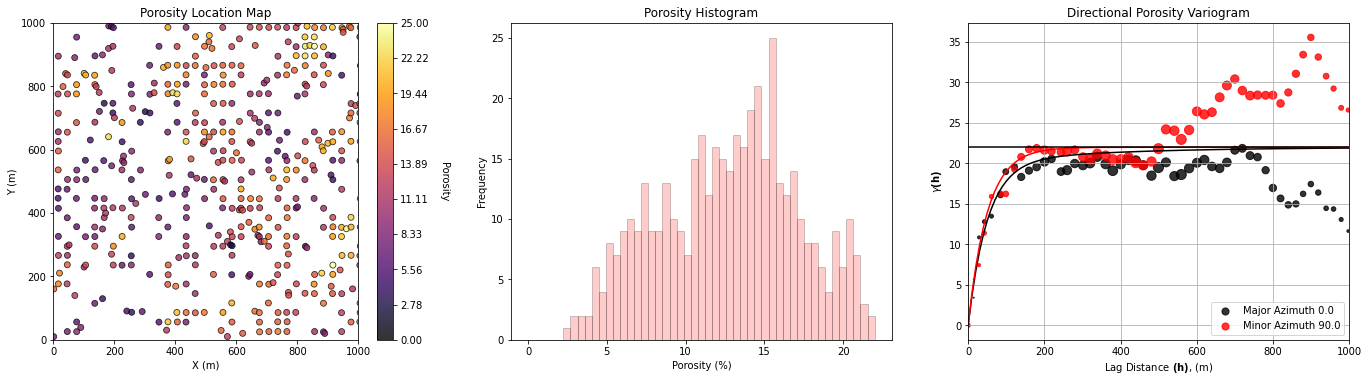

In [6]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000,0,25,'Porosity Location Map','X (m)','Y (m)','Porosity',cmap=cmap)

plt.subplot(132)
plt.hist(df['Porosity'].values,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.2,edgecolor='black')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram')


df['Npor'], tvPor, tnsPor = geostats.nscore(df,'Porosity') 
lags, gamma_maj, npps_maj = geostats.gamv(df,"X","Y",'Porosity',tmin,tmax,xlag=20,xltol=20,nlag=100,azm=0.0,atol=22.5,bandwh=9999.9,isill=0);
lags, gamma_min, npps_min = geostats.gamv(df,"X","Y",'Porosity',tmin,tmax,xlag=20,xltol=20,nlag=100,azm=90.0,atol=22.5,bandwh=9999.9,isill=0);

nug = 0; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 2; cc1 = 20.0; azi1 = 0; hmaj1 = 150; hmin1 = 150
it2 = 2; cc2 = 2.0; azi2 = 0; hmaj2 = 1000; hmin2 = 150

vmodel = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2); # make model object
vmodel_sim = GSLIB.make_variogram(nug,nst,it1,cc1/(cc1+cc2),azi1,hmaj1,hmin1,it2,cc2/(cc1+cc2),azi2,hmaj2,hmin2); # make model object

plt.subplot(133)
vargplot('Porosity',lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Simple Kriging

Let's make a simple kriging, estimation map and calculate the same statistics again to check the reproduction.

  Estimated   10000 blocks 
      average   12.193761448284178  variance  12.312907779370704
 x,y,z offsets = 0.0,10.0
 x,y,z offsets = 10.0,1.794896514920806e-08


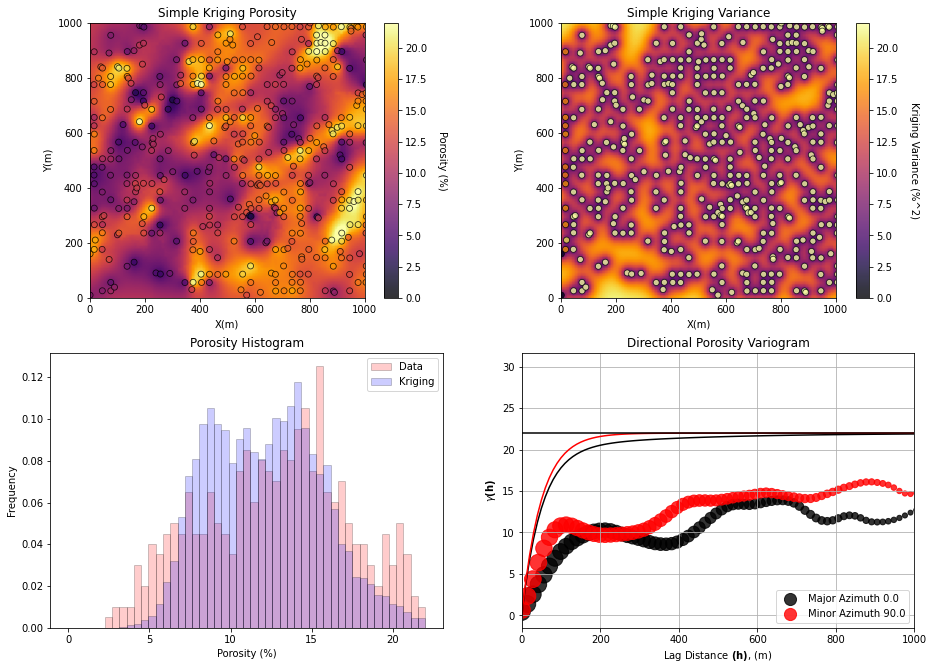

In [7]:
por_kmap, por_vmap = geostats.kb2d(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=1,nydis=1,
         ndmin=0,ndmax=10,radius=500,ktype=0,skmean=pormean,vario=vmodel)

plt.subplot(221)                                          # plot the results
GSLIB.locpix_st(por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Simple Kriging Porosity','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(222)                                          # plot the results
GSLIB.locpix_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0,porvar,df,'X','Y','X','Simple Kriging Variance','X(m)','Y(m)','Kriging Variance (%^2)',cmap)


plt.subplot(223)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.2,edgecolor='black',label='Data')
plt.hist(por_kmap.flatten(),density=True,bins=np.linspace(pormin,pormax,50),color='blue',alpha=0.2,edgecolor='black',label='Kriging')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram'); plt.legend(loc='upper right')

lags, sk_gamma_maj, npps_maj = geostats.gam(por_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=-1,nlag=100,isill=0.0);
lags, sk_gamma_min, npps_min = geostats.gam(por_kmap,tmin,tmax,xsiz,ysiz,ixd=1,iyd=1,nlag=100,isill=0.0);

plt.subplot(224)
vargplot('Porosity',lags,sk_gamma_maj,sk_gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)
plt.show()

#### Sequential Gaussian Simulation

Let's jump right to building a variety of models with simulation and visualizing the results.  We will start with a test, comparision of simulation with simple and ordinary kriging.


 Data for SGSIM: Number of acceptable data     = 457
                 Number trimmed                = 0
                 Weighted Average              = 13.0177
                 Weighted Variance             = 22.0017
                 Weighted Transformed Average  = 0.0005
                 Weighted Transformed Variance = 0.9953
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = -0.1936 (close to 0.0?)
                                   variance = 1.2106 (close to gammabar(V,V)? approx. 1.0)
 x,y,z offsets = 0.0,10.0
 x,y,z offsets = 10.0,1.794896514920806e-08


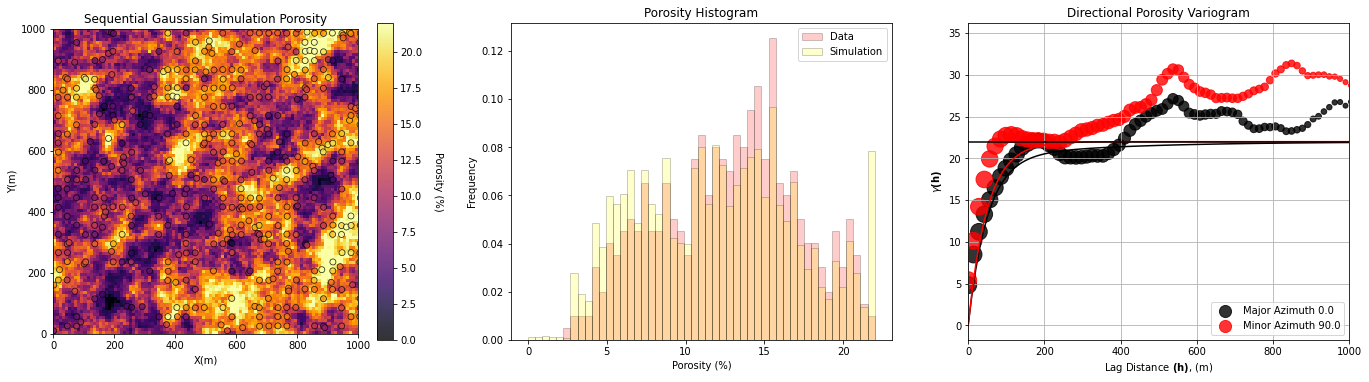

In [9]:
# Simple Kriging vs. Ordinary Kriging

por_sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=pormin,zmax=pormax,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=0,ndmax=20,nodmax=20,mults=0,nmult=2,noct=-1,radius=500,radius1=500,sang1=0,
            mxctx=41,mxcty=41,ktype=0,colocorr=0.0,sec_map=0,vario=vmodel_sim)

plt.subplot(131)                                          # plot the results
GSLIB.locpix_st(por_sim,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Sequential Gaussian Simulation Porosity','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(132)
plt.hist(df['Porosity'].values,density=True,bins=np.linspace(pormin,pormax,50),color='red',alpha=0.2,edgecolor='black',label='Data')
plt.hist(por_sim.flatten(),density=True,bins=np.linspace(pormin,pormax,50),color='yellow',alpha=0.2,edgecolor='black',label='Simulation')
plt.xlabel('Porosity (%)'); plt.ylabel('Frequency'); plt.title('Porosity Histogram'); plt.legend(loc='upper right')

lags, sim_gamma_maj, npps_maj = geostats.gam(por_sim,tmin,tmax,xsiz,ysiz,ixd=1,iyd=-1,nlag=100,isill=0.0);
lags, sim_gamma_min, npps_min = geostats.gam(por_sim,tmin,tmax,xsiz,ysiz,ixd=1,iyd=1,nlag=100,isill=0.0);

plt.subplot(133)
vargplot('Porosity',lags,sim_gamma_maj,sim_gamma_min,npps_maj,npps_min,vmodel,azi=0.0,atol=22.5,sill=porvar)     # plot the variogram

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.1, wspace=0.2, hspace=0.2)
plt.show()

#### Comments

This was a basic demonstration comparison of spatial estimation and simulation.   

Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations and many other workflows available at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy. 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

<i>&copy; Copyright daytum 2021. All Rights Reserved</i>